[](http://)

# Recency, Frequency and Monetary Clustering

## Library

**Import Libraries and DataSet**

In [29]:
# import library
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import datetime as dt

#For Data  Visualization
import matplotlib.pyplot as plt
import seaborn as sns


df = pd.read_excel('Online_Retail.xlsx')

## Dataset Information and Collection

**Explore data and data information**

**Data Set Information:**

This Online Retail II data set contains all the transactions occurring for a UK-based and registered, non-store online retail between 01/12/2009 and 09/12/2011.The company mainly sells unique all-occasion gift-ware. Many customers of the company are wholesalers.

**Attribute Information:**

1. InvoiceNo: Invoice number. Nominal. A 6-digit integral number uniquely assigned to each transaction. If this code starts with the letter 'c', it indicates a cancellation.
2. StockCode: Product (item) code. Nominal. A 5-digit integral number uniquely assigned to each distinct product.
3. Description: Product (item) name. Nominal.
4. Quantity: The quantities of each product (item) per transaction. Numeric.
5. InvoiceDate: Invoice date and time. Numeric. The day and time when a transaction was generated.
6. UnitPrice: Unit price. Numeric. Product price per unit in sterling.
7. CustomerID: Customer number. Nominal. A 5-digit integral number uniquely assigned to each customer.
8. Country: Country name. Nominal. The name of the country where a customer resides.

In [30]:
df.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


# Data Preparation

## Data Cleaning

#### Data Understanding

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


**Nots that: There are Missing Data in Description and The Customer ID Columns , let's check that**

#### Missing data treatment

In [32]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [33]:
df= df.dropna(subset=['CustomerID'])

In [34]:
df.isnull().sum().sum()

0

#### Duplication data treatment

In [35]:
df.duplicated().sum()


5225

In [36]:
df = df.drop_duplicates()

In [37]:
df.duplicated().sum()


0

#### Data Manipulation

In [38]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,401604.000000,401604.000000,401604.000000
mean,12.183273,3.474064,15281.160818
std,250.283037,69.764035,1714.006089
min,-80995.000000,0.000000,12346.000000
25%,2.000000,1.250000,13939.000000
50%,5.000000,1.950000,15145.000000
75%,12.000000,3.750000,16784.000000
max,80995.000000,38970.000000,18287.000000


Note That : The min for unit price = 0 and the min for Quantity with negative value 

In [11]:
df=df[(df['Quantity']>0) & (df['UnitPrice']>0)]
df.describe() 

,Quantity,UnitPrice,CustomerID
count,392692.000000,392692.000000,392692.000000
mean,13.119702,3.125914,15287.843865
std,180.492832,22.241836,1713.539549
min,1.000000,0.001000,12346.000000
25%,2.000000,1.250000,13955.000000
50%,6.000000,1.950000,15150.000000
75%,12.000000,3.750000,16791.000000
max,80995.000000,8142.750000,18287.000000


In [12]:
df.shape

(392692, 8)

In [13]:
#New Total Sum Column  
df['TotalSum'] = df['UnitPrice']* df['Quantity']

#Data preparation steps
print('Min Invoice Date:',df.InvoiceDate.dt.date.min(),'max Invoice Date:',
       df.InvoiceDate.dt.date.max())

df.head(3)

Min Invoice Date: 2010-12-01 max Invoice Date: 2011-12-09


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalSum
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00


In the real world, we would be working with the most recent snapshot of the data of today or yesterday

## Data Transformation

In [14]:
snapshot_date = df['InvoiceDate'].max() + dt.timedelta(days=1)
snapshot_date
#The last day of purchase in total is 09 DEC, 2011. To calculate the day periods, 
#let's set one day after the last one,or 
#10 DEC as a snapshot_date. We will cound the diff days with snapshot_date.


Timestamp('2011-12-10 12:50:00')

In [15]:
# Calculate RFM metrics
rfm = df.groupby(['CustomerID']).agg({'InvoiceDate': lambda x : (snapshot_date - x.max()).days,
                                      'InvoiceNo':'count','TotalSum': 'sum'})
#Function Lambdea: it gives the number of days between hypothetical today and the last transaction

#Rename columns
rfm.rename(columns={'InvoiceDate':'Recency','InvoiceNo':'Frequency','TotalSum':'MonetaryValue'}
           ,inplace= True)

#Final RFM values
rfm.head()


,Recency,Frequency,MonetaryValue
CustomerID,,,
12346.0,326,1,77183.60
12347.0,2,182,4310.00
12348.0,75,31,1797.24
12349.0,19,73,1757.55
12350.0,310,17,334.40


#### RFM Segments & RFM Score

In [18]:
#Building RFM segments
r_labels =range(4,0,-1)
f_labels=range(1,5)
m_labels=range(1,5)
r_quartiles = pd.qcut(rfm['Recency'], q=4, labels = r_labels)
f_quartiles = pd.qcut(rfm['Frequency'],q=4, labels = f_labels)
m_quartiles = pd.qcut(rfm['MonetaryValue'],q=4,labels = m_labels)
rfm = rfm.assign(R=r_quartiles,F=f_quartiles,M=m_quartiles)

# Build RFM Segment and RFM Score
def add_rfm(x) : return str(x['R']) + str(x['F']) + str(x['M'])
rfm['RFM_Segment'] = rfm.apply(add_rfm,axis=1 )
rfm['RFM_Score'] = rfm[['R','F','M']].sum(axis=1)

rfm.head()

,Recency,Frequency,MonetaryValue,R,F,M,RFM_Segment,RFM_Score
CustomerID,,,,,,,,
12346.0,326,1,77183.60,1,1,4,114,6
12347.0,2,182,4310.00,4,4,4,444,12
12348.0,75,31,1797.24,2,2,4,224,8
12349.0,19,73,1757.55,3,3,4,334,10
12350.0,310,17,334.40,1,1,2,112,4


#### Data Checking

In [19]:
#Select bottom RFM segment "111" and view top 5 rows
rfm[rfm['RFM_Segment']=='111'].head()

,Recency,Frequency,MonetaryValue,R,F,M,RFM_Segment,RFM_Score
CustomerID,,,,,,,,
12353.0,204,4,89.00,1,1,1,111,3
12361.0,287,10,189.90,1,1,1,111,3
12401.0,303,5,84.30,1,1,1,111,3
12402.0,323,11,225.60,1,1,1,111,3
12441.0,367,11,173.55,1,1,1,111,3


# Analyze RFM Result

## RFM Score Summary

In [20]:
rfm.groupby('RFM_Score').agg({'Recency': 'mean','Frequency': 'mean',
                             'MonetaryValue': ['mean', 'count'] }).round(1)



Recency Frequency MonetaryValue      
             mean      mean          mean count
RFM_Score                                      
3           260.7       8.2         157.4   381
4           177.2      13.6         240.0   388
5           152.9      21.2         366.6   518
6            95.9      27.9         820.8   457
7            79.6      38.0         758.1   463
8            64.1      56.0         987.3   454
9            45.9      78.7        1795.1   414
10           32.4     110.5        2056.4   426
11           21.3     186.9        4062.0   387
12            7.2     367.8        9285.9   450

## RFM Segments Definition

In [70]:
#gunain R dan F karena M sudah sejalan dengan F jadi untuk sederhana
seg_map = {
    r'[1-2][1-2]': 'Hibernating',
    r'[1-2]3': 'At Risk',
    r'[1-2]4': 'Can\'t Loose',
    r'31': 'About to Sleep',
    r'33': 'Need Attention',
    r'[3-4][4-5]': 'Loyal Customers',
    r'41': 'Promising',
    r'32': 'New Customers',
    r'[4-5]2': 'Potential Loyalists',
    r'43': 'Champions'
}

## RFM Score Grouping

In [71]:
rfm['Segment'] = rfm['R'].astype(str) + rfm['F'].astype(str)
rfm['Segment check'] = rfm['Segment']
rfm['Segment'] = rfm['Segment'].replace(seg_map, regex=True)
rfm.head()

,Recency,Frequency,Monetary,R,F,M,RFM_Segment,Segment,Segment check
CustomerID,,,,,,,,,
12346.0,326,1,77183.60,1,1,4,114,Hibernating,11
12347.0,2,182,4310.00,4,4,4,444,Loyal Customers,44
12348.0,75,31,1797.24,2,2,4,224,Hibernating,22
12349.0,19,73,1757.55,3,3,4,334,Need Attention,33
12350.0,310,17,334.40,1,1,2,112,Hibernating,11


In [72]:
rfm_final = rfm.copy()

In [73]:
rfm = rfm.rename(columns={'MonetaryValue': 'Monetary'})
rfm = rfm.drop('RFM_Score', axis=1)
rfm.groupby('Segment').mean().sort_values('Monetary')

,Recency,Frequency,Monetary
Segment,,,
About to Sleep,33.727778,9.544444,380.526667
Hibernating,183.479866,17.279195,552.501209
New Customers,33.979424,28.584362,628.011728
Potential Loyalists,9.628743,29.107784,906.732934
At Risk,136.448802,63.278867,1080.929085
Need Attention,31.174051,66.034810,1315.623864
Champions,9.174061,68.058020,1874.569522
Promising,9.990909,9.309091,2137.812091
Can't Loose,107.412935,158.572139,2408.463537


In [74]:
rfm_graph = rfm.copy()
rfm_graph['CustomerID'] = rfm_graph.index
#calculate sum of points for each team
rfm_graph = rfm_graph[['Segment','CustomerID']].groupby(['Segment']).count()
rfm_graph
# # #create bar plot with custom aesthetics
# rfm_graph.plot.barh(x='Segment', y='CustomerID',
#              title='RFM Segmentation', color='green')

# #rotate x-axis ticks vertically
# plt.xticks(rotation=0)

,CustomerID
Segment,
About to Sleep,180
At Risk,459
Can't Loose,201
Champions,293
Hibernating,1490
Loyal Customers,879
Need Attention,316
New Customers,243
Potential Loyalists,167


## RFM Data Visualization

<AxesSubplot:title={'center':'RFM Segmentation'}, ylabel='Segmentation'>

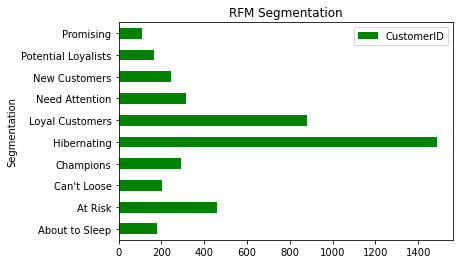

In [75]:
rfm_graph['Segmentation'] = rfm_graph.index
rfm_graph.plot.barh(x='Segmentation', y='CustomerID',
             title='RFM Segmentation', color='green')

**Reference**
- Customer segmentation on DataCamp course by Karolis Urbonas "Head of Data Science, Amazon" https://www.datacamp.com/courses/customer-segmentation-in-python
- https://clevertap.com/blog/rfm-analysis/
- https://clevertap.com/blog/cohort-analysis/
- https://towardsdatascience.com/who-is-your-golden-goose-cohort-analysis-50c9de5dbd31
- https://www.kaggle.com/code/mahmoudelfahl/cohort-analysis-customer-segmentation-with-rfm/data




<br>